Week 10: Neural Nets Regression

5.1 Noisy Lennard-Jones-Gauss data

In [1]:
# create some noise LJ data

def LJ_pot(r,eps=1,sigma=1):
    V = 4*eps*((sigma/r)**12-(sigma/r)**6)
    return V


-0.3203365942785745


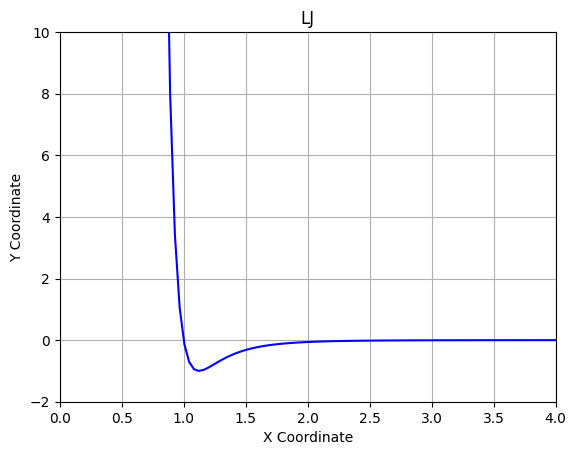

In [2]:
import numpy as np
import matplotlib.pyplot as plt

print(LJ_pot(1.5))
xs = np.linspace(0.2,4,100)
ys = LJ_pot(xs,1,1)

# Plot the original input points
plt.plot(xs, ys, color='blue')

# Labeling the plot
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('LJ')
plt.xlim(0,4)
plt.ylim(-2,10)
plt.grid(True)

# Show the plot
plt.show()

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def noisy_LJ(xs, noise_level, seed=42):
    np.random.seed(seed)
    ys = LJ_pot(xs)
    noise = noise_level * np.random.uniform(-1, 1, size=xs.shape)
    return ys + noise



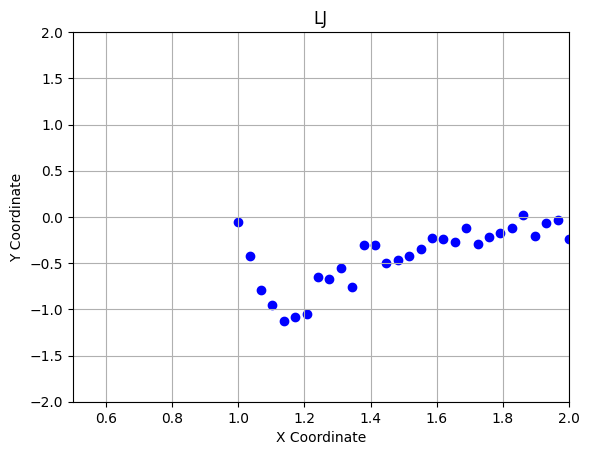

In [25]:


xs = np.linspace(1, 2, 30)
ys = noisy_LJ(xs, 0.2)

# Plot the original input points
plt.scatter(xs, ys, color='blue')

# Labeling the plot
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('LJ')
plt.xlim(0.5, 2)
plt.ylim(-2, 2)
plt.grid(True)

# Show the plot
plt.show()


5.2 Deep neural network fit

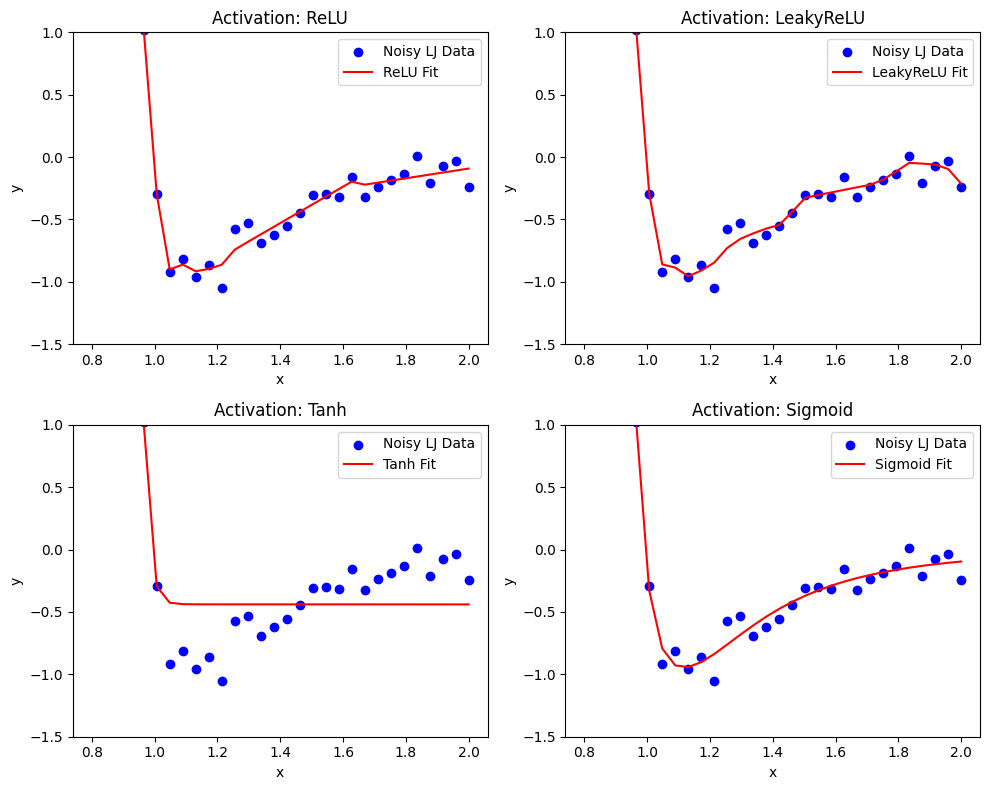

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define the Lennard-Jones potential
def LJ_pot(xs):
    return 4 * ((1 / xs) ** 12 - (1 / xs) ** 6)

# Add noise to the LJ potential
def noisy_LJ(xs, noise_level, seed=None):
    if seed is not None:
        np.random.seed(seed)
    ys = LJ_pot(xs)
    noise = noise_level * np.random.uniform(-1, 1, size=xs.shape)
    return ys + noise

class LJNet(nn.Module):
    def __init__(self, layer_sizes, activation_func):
        """
        Initialize a flexible feedforward network.
        
        Args:
        - layer_sizes (list): A list defining the number of neurons in each layer. 
                              For example, [1, 64, 128, 64, 1] defines a network with:
                              - Input layer (1 neuron)
                              - 3 hidden layers with 64, 128, and 64 neurons
                              - Output layer (1 neuron)
        - activation_func (callable): Activation function to use in the network.
        """
        super(LJNet, self).__init__()
        
        self.layers = nn.ModuleList()  # Store layers dynamically
        self.activation = activation_func
        
        # Create linear layers dynamically based on layer_sizes
        for i in range(len(layer_sizes) - 1):
            self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
    
    def forward(self, x):
        for layer in self.layers[:-1]:  # Apply activation after all but the last layer
            x = self.activation(layer(x))
        x = self.layers[-1](x)  # Linear output for the final layer
        return x


# Training function
def train_model(x_train, y_train, activation_func, architecture, epochs=1000, lr=0.01):
    model = LJNet(architecture, activation_func)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

    # Get predictions
    model.eval()
    with torch.no_grad():
        predictions = model(x_train).numpy()
    return predictions

# Prepare data
xs = np.linspace(0.8, 2, 30)
ys = noisy_LJ(xs, 0.2, seed=42)
x_train = torch.tensor(xs, dtype=torch.float32).view(-1, 1)
y_train = torch.tensor(ys, dtype=torch.float32).view(-1, 1)

# Define activation functions
activation_functions = {
    "ReLU": nn.ReLU(),
    "LeakyReLU": nn.LeakyReLU(),
    "Tanh": nn.Tanh(),
    "Sigmoid": nn.Sigmoid()
}

architectures = [1, 32, 64, 32, 1],  # Wider network


# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

# Train and plot for each activation function
for i, (name, activation_func) in enumerate(activation_functions.items()):
    predictions = train_model(x_train, y_train, activation_func=activation_func, architecture=architectures[0])
    axes[i].scatter(xs, ys, label='Noisy LJ Data', color='blue')
    axes[i].plot(xs, predictions, label=f'{name} Fit', color='red')
    axes[i].set_title(f'Activation: {name}')
    axes[i].set_xlabel('x')
    axes[i].set_ylabel('y')
    axes[i].set_ylim(-1.5, 1)
    axes[i].legend()

plt.tight_layout()
plt.show()

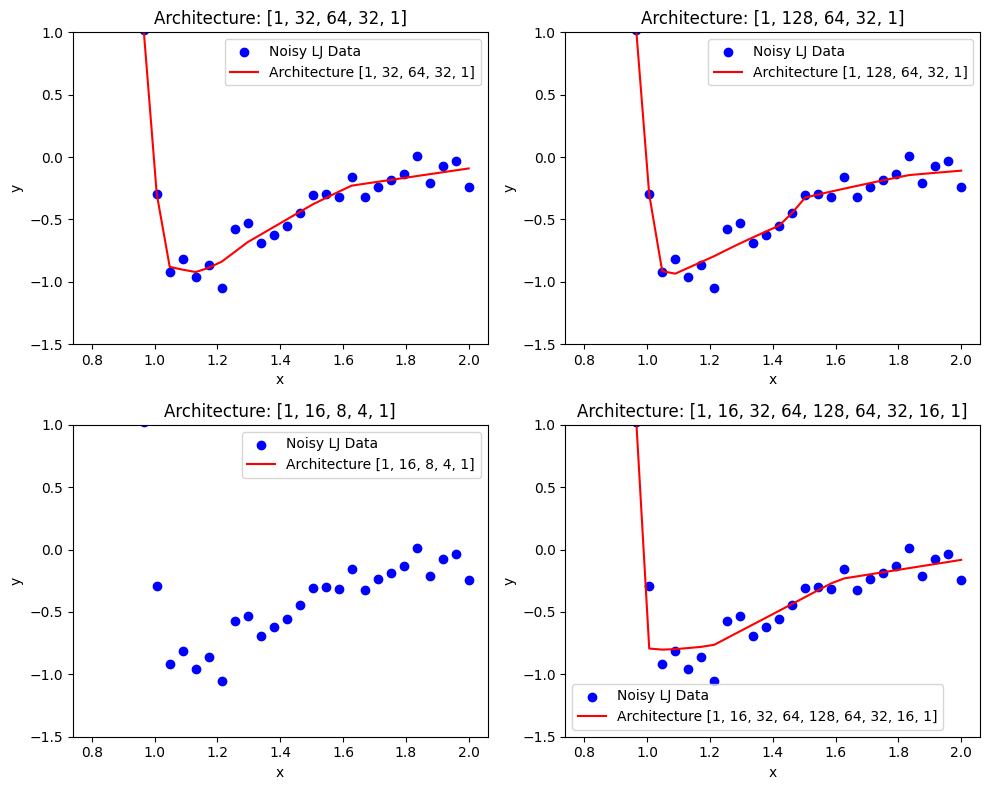

In [ ]:
architectures = [
    [1, 32, 64, 32, 1],  # Wider network
    [1, 128, 64, 32, 1],  # Deeper network
    [1, 16, 8, 4, 1],     # Narrower network
    [1,16,32,64,128,64,32,16,1], 
]

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

activation_func = nn.ReLU() 

for i, architecture in enumerate(architectures):  # Use the architectures list directly
    predictions = train_model(x_train, y_train, activation_func=activation_func, architecture=architecture)
    axes[i].scatter(xs, ys, label='Noisy LJ Data', color='blue')
    axes[i].plot(xs, predictions, label=f'Architecture {architecture}', color='red')
    axes[i].set_title(f'Architecture: {architecture}')
    axes[i].set_xlabel('x')
    axes[i].set_ylabel('y')
    axes[i].set_ylim(-1.5, 1)
    axes[i].legend()

plt.tight_layout()
plt.show()


ex 52: 6.1 overfitting

Parameter containing:
tensor(1., requires_grad=True)
Parameter containing:
tensor(0.5000, requires_grad=True)
A = 1.0
b = 0.5
Step 0, Loss: 0.2672311067581177
Step 500, Loss: 0.2562805116176605
Step 1000, Loss: 0.255262166261673
Step 1500, Loss: 0.25503528118133545
Step 2000, Loss: 0.2549847662448883
Step 2500, Loss: 0.25497347116470337
Step 3000, Loss: 0.2549709677696228
Step 3500, Loss: 0.25497034192085266
Step 4000, Loss: 0.2549702525138855
Step 4500, Loss: 0.2549702525138855
Step 5000, Loss: 0.2549702227115631
Step 5500, Loss: 0.2549702525138855
Step 6000, Loss: 0.2549702525138855
Step 6500, Loss: 0.2549702525138855
Step 7000, Loss: 0.2549702525138855
Step 7500, Loss: 0.2549702525138855
Step 8000, Loss: 0.2549702525138855
Step 8500, Loss: 0.2549702525138855
Step 9000, Loss: 0.2549702525138855
Step 9500, Loss: 0.2549702525138855
A = 0.9388580322265625
b = 0.5748094916343689
1 0.5


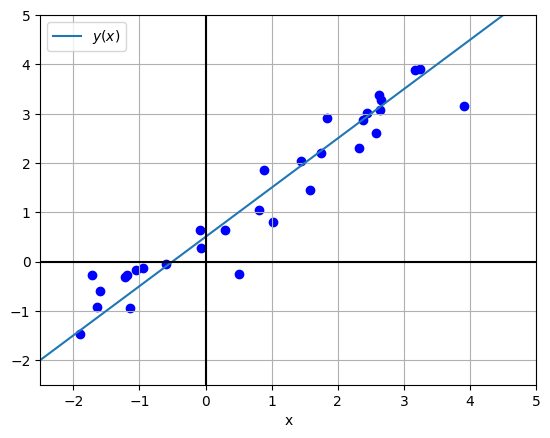

In [49]:
w = 1
b = 0.5
xs_train = torch.rand(32) * 6 - 2
ys_train = w * xs_train + b + 0.5 * torch.randn(32)

class LinModel(torch.nn.Module):
    def __init__(self,A=1, b=1):
        super().__init__()
        self.A = torch.nn.Parameter(torch.tensor(float(A)))
        self.b = torch.nn.Parameter(torch.tensor(float(b)))

    def forward(self, x): # We implement the forward pass
        return self.A * x + self.b
    
A = 1
b = 0.5

model = LinModel(A=A, b=b)
model(1)

for parameter in model.parameters():
    print(parameter)

for name, parameter in model.named_parameters():
    print(name, '=', parameter.data.item())

steps = 10000

optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

for step in range(steps):
    y_pred = model(xs_train)
    loss = torch.mean((y_pred - ys_train) ** 2)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step % 500 == 0:
        print(f'Step {step}, Loss: {loss.item()}')

for name, parameter in model.named_parameters():
    print(name, '=', parameter.data.item())  # This prints all parameter names and their values
    if name == 'layers.0.weight':  # Replace with the specific parameter name
        A = parameter.data.item()
    elif name == 'layers.0.bias':  # Replace with another specific parameter name
        b = parameter.data.item()


print(A,b)
def lin_func(x,A,b):
    return A*x+b

# Create a figure and an axes
fig, ax = plt.subplots()
xs = torch.linspace(-10, 10, 100, requires_grad=True)
ys = lin_func(xs,A,b)
yps = torch.autograd.grad(ys, xs, grad_outputs=torch.ones_like(xs))[0]

with torch.no_grad():
    ax.plot(xs, ys, label='$y(x)$')  # No conversion to numpy

ax.set_xlabel("x")
ax.grid(True)
ax.axhline(0, color='k')
ax.axvline(0, color='k')
ax.set_xlim([-2.5, 5])  # Set the y-axis limits
ax.set_ylim([-2.5, 5])  # Set the y-axis limits
ax.legend()

# Plot data points
plt.scatter(xs_train,ys_train, color='blue', label='Data points')

plt.show()  # Display the plot